<a href="https://colab.research.google.com/github/Ai-deen/DS605-Sign-Lanaguage-Translation-Project/blob/main/DS605_project_SLT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# German

## RNN with Attention


### Preprocessing


In [ ]:
!pip install "tensorflow-text>=2.11"
!pip install einops

In [ ]:
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

In [ ]:
from pathlib import Path

def load_data(file_path):
    # Use the Path class to create a Path object
    path = Path(file_path)

    # Open the file and read its content
    with path.open(mode='r', encoding='utf-8') as file:
        file_content = file.read()

    lines = file_content.splitlines()
    lines = np.array([i for i in lines])

    return lines

# Provide the correct file path
context = load_data("/content/src-train.txt")
target = load_data("/content/tgt-train.txt")

In [ ]:
BUFFER_SIZE = len(context)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target),)) < 0.8

train = (
    tf.data.Dataset
    .from_tensor_slices((context[is_train], target[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val = (
    tf.data.Dataset
    .from_tensor_slices((context[~is_train], target[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [ ]:
for example_context_strings, example_target_strings in train.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'vor allem im osten bildet sich stellenweise nebel'
 b'im westen aber die abk\xc3\xbchlung schon unterwegs und die ging mit starken gewittern einher also in brandenburg hat es dann auch heute nachmittag schon kr\xc3\xa4ftig gewittert'
 b'sehr durchwachsen das sommerwetter heute mit schauern aber auch mit sonne'
 b'am samstag wird es deutlich k\xc3\xbchler dabei ist es wechselhaft und teilweise windig'
 b'in den n\xc3\xa4chsten tagen wird es noch w\xc3\xa4rmer allerdings die hitze hier im osten die bekommen wir nicht'], shape=(5,), dtype=string)

tf.Tensor(
[b'speziell ost koennen nebel'
 b'west kuehl sinken schon gleich zeit gewitter stark brand burg heute nach mittag regen gewitter sehen'
 b'wetter heute wechsel regen auch'
 b'samstag enorm mehr kuehl auch wechselhaft moeglich teil wind moeglich'
 b'in-kommend mehr warm aber ost region heiss kommen neg-haben neg-nein'], shape=(5,), dtype=string)


In [ ]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [ ]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [ ]:
context_text_processor.adapt(train.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', 'und', 'im', 'es', 'der', 'am', 'in']

In [ ]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['',
 '[UNK]',
 '[START]',
 '[END]',
 'regen',
 'region',
 'ix',
 'kommen',
 'morgen',
 'nord']

In [ ]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 48, 66, 5, 42, 227, 22, 121, 86, 3],
 [2, 5, 36, 34, 10, 728, 97, 395, 4, 10, 2327, 31, 327, 174, 1302, 207, 9,
  527, 301, 6, 33, 11, 19, 153, 97, 169, 1548, 3]                         ,
 [2, 133, 721, 30, 1937, 19, 31, 152, 34, 11, 31, 26, 3]]>

In [ ]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] vor allem im osten bildet sich stellenweise nebel [END]'

Text(0.5, 1.0, 'Mask')

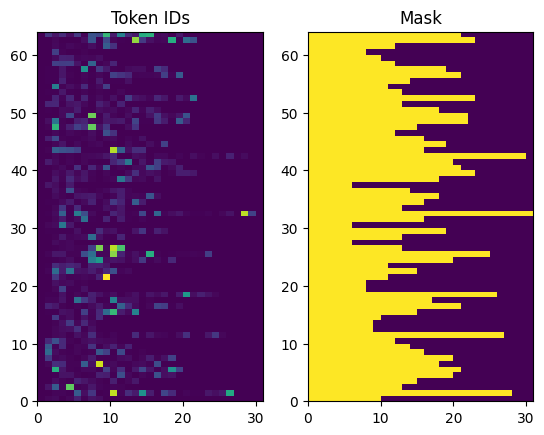

In [ ]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

In [ ]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train.map(process_text, tf.data.AUTOTUNE)
val_ds = val.map(process_text, tf.data.AUTOTUNE)

In [ ]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy())
  print()
  print(ex_tar_in[0, :10].numpy())
  print(ex_tar_out[0, :10].numpy())

[  2   4 610 193   6   9  14 126 124  31]

[  2  66  89 159  64 138   4  17  24  17]
[ 66  89 159  64 138   4  17  24  17  56]


### Build the model

In [ ]:
UNITS = 256

In [ ]:
#@title
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [ ]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 26)
Encoder output, shape (batch, s, units): (64, 26, 256)


In [ ]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()

    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)

    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')

    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [ ]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 26, 256)
Target sequence, shape (batch, t, units): (64, 17, 256)
Attention result, shape (batch, t, units): (64, 17, 256)
Attention weights, shape (batch, t, s):    (64, 17, 26)


In [ ]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([0.9999999 , 0.99999994, 1.        , 0.99999994, 1.0000001 ,
       0.99999994, 0.99999994, 1.        , 1.        , 1.        ,
       1.        , 0.99999976, 0.9999998 , 1.        , 1.        ,
       1.        , 1.        ], dtype=float32)

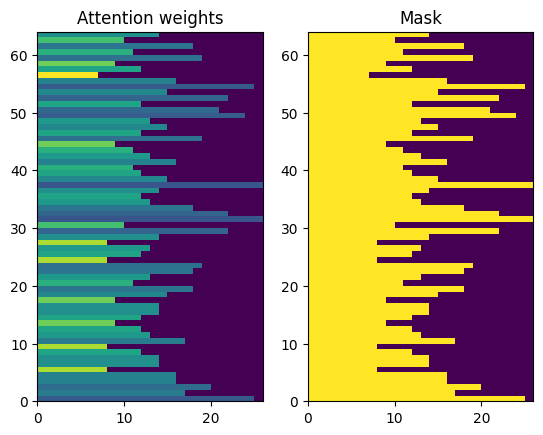

In [ ]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');


In [ ]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [ ]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

In [ ]:
decoder = Decoder(target_text_processor, UNITS)

In [ ]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 26, 256)
input target tokens shape: (batch, t) (64, 17)
logits shape shape: (batch, target_vocabulary_size) (64, 17, 1019)


In [ ]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [ ]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [ ]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True)

  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

  return next_token, done, state

In [ ]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'gefrieren erhoehen ungefaehr nordrhein wahr ankommen v schlaf leider siebte',
       b'sinken zuende zuschauer irland bauer vorallem gehoert dienstag bisjetzt ostbayern',
       b'raum vogel auffuellen rechnen streifen wunderbar italien einpaar fuenf negmehr'],
      dtype=object)

In [ ]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy.
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [ ]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 26)
Target tokens, shape: (batch, t) (64, 17)
logits, shape: (batch, t, target_vocabulary_size) (64, 17, 1019)


In [ ]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [ ]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [ ]:
model.compile(optimizer='adam',
              loss=masked_loss,
              metrics=[masked_acc, masked_loss])

In [ ]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 6.926577, 'expected_acc': 0.0009813542688910696}

In [ ]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 12s 246ms/step - loss: 6.9546 - masked_acc: 0.0024 - masked_loss: 6.9546


{'loss': 6.954649448394775,
 'masked_acc': 0.0024363480042666197,
 'masked_loss': 6.954649448394775}

### Train the model


In [ ]:
history = model.fit(
    train_ds.repeat(),
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100
100/100 [==============================] - 66s 534ms/step - loss: 4.2699 - masked_acc: 0.2139 - masked_loss: 4.2661 - val_loss: 3.5040 - val_masked_acc: 0.2985 - val_masked_loss: 3.5040
Epoch 2/100
100/100 [==============================] - 53s 527ms/step - loss: 3.0320 - masked_acc: 0.3713 - masked_loss: 3.0298 - val_loss: 3.0400 - val_masked_acc: 0.3749 - val_masked_loss: 3.0400
Epoch 3/100
100/100 [==============================] - 53s 529ms/step - loss: 2.4896 - masked_acc: 0.4519 - masked_loss: 2.4895 - val_loss: 2.8460 - val_masked_acc: 0.4153 - val_masked_loss: 2.8460
Epoch 4/100
100/100 [==============================] - 53s 531ms/step - loss: 2.1170 - masked_acc: 0.5064 - masked_loss: 2.1167 - val_loss: 2.7990 - val_masked_acc: 0.4241 - val_masked_loss: 2.7990
Epoch 5/100
100/100 [==============================] - 54s 536ms/step - loss: 1.8791 - masked_acc: 0.5437 - masked_loss: 1.8783 - val_loss: 2.7887 - val_masked_acc: 0.4325 - val_masked_loss: 2.7887
Epoch 6/10

### Evaluating the model

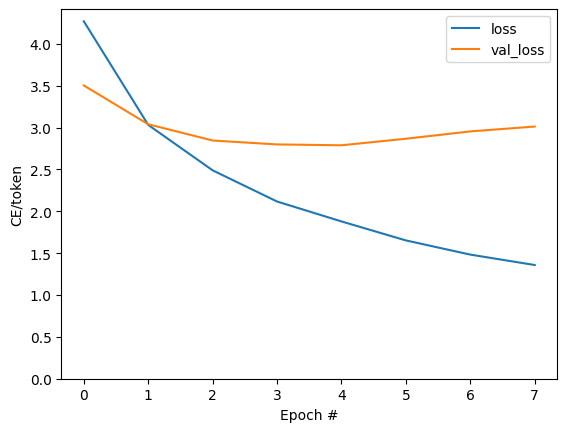

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

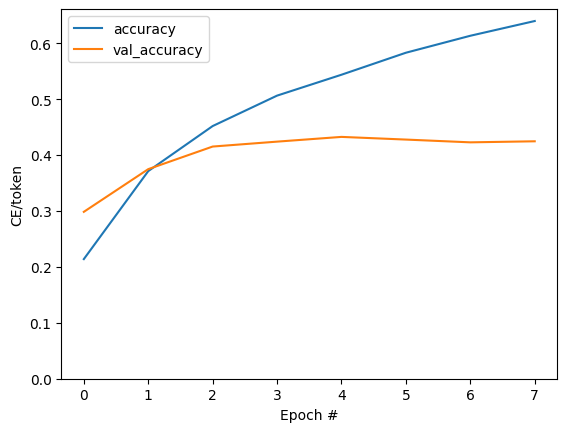

In [ ]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [ ]:
#@title
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)

    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [ ]:
# File paths
input_file_path = "/content/src-test.txt"  # Replace with the path to your input text file
output_file_path = "tgt-pred.txt"  # Replace with the desired path for the output text file

# Open the input file and read sentences
with open(input_file_path, "r", encoding="utf-8") as input_file:
    input_sentences = input_file.readlines()

# Perform translation and write to the output file
with open(output_file_path, "w", encoding="utf-8") as output_file:
    for sentence in input_sentences:
        # Perform translation for each sentence
        result = model.translate([sentence])
        decoded_sentence = result[0].numpy().decode()

        # Write the decoded sentence to the output file
        output_file.write(decoded_sentence + "\n")


### BLEU Scores and Translations

In [ ]:
!touch bleu.py

In [ ]:
!python bleu.py 1 /content/tgt-test.txt  /content/tgt-pred.txt
!python bleu.py 2 /content/tgt-test.txt  /content/tgt-pred.txt
!python bleu.py 3 /content/tgt-test.txt  /content/tgt-pred.txt
!python bleu.py 4 /content/tgt-test.txt  /content/tgt-pred.txt


0.5361163227016885
0.34551920189732355
0.2331989418912198
0.15928302179603324


In [ ]:
!head /content/tgt-pred.txt

regen schnee nord region klar himmel stern koennen sehen 
donnerstag nord regen sued sonne wolke wechselhaft wetter aber freitag auch freitag 
sued kommen tief kommen stark regen schnee teilweise gefrieren regen 
samstag sonntag samstag bis samstag eins zwanzig grad ost region 
deutsch land morgen hoch kommen 
sonntag nordwest mischung sonne wolke wechselhaft und donner ix 
schauer gewitter koennen 
inkommend weiter wind dabei schon schnee aber viel schnee 
wochenende dann mehr kalt 
morgen wetter ruhig viel wolke sonne haben 


##OpenNMT


In [ ]:
# Install OpenNMT
!pip install OpenNMT-py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.3/257.3 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 34.3 MB/s eta 0:00:00


### Preprocessing

In [ ]:
# Tokenize source and target text
!onmt-tokenize-text --tokenizer OpenNMTTokenizer --mode aggressive < /content/Data/src-train.txt > Data/source_tokenized_de.txt
!onmt-tokenize-text --tokenizer OpenNMTTokenizer --mode aggressive < /content/Data/tgt-train.txt > Data/target_tokenized_de.txt

# Create vocabularies
!onmt-build-vocab --size 50000 --save_vocab Data/source_vocab.txt Data/source_tokenized_de.txt
!onmt-build-vocab --size 50000 --save_vocab Data/target_vocab.txt Data/target_tokenized_de.txt

2023-11-18 13:12:29.717289: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-18 13:12:29.717348: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-18 13:12:29.718682: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-18 13:12:30.835163: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/opennmt/version.py:23: UserWarning: OpenNMT-tf supports TensorFlow versions 2.6.0 (included) to 2.14.0 (excluded), but you have TensorFlow 2.15.0 installed. Some features might not work properly.
  war

In [ ]:
!onmt-tokenize-text --tokenizer OpenNMTTokenizer --mode aggressive --source_words_vocabulary data/source_vocab.txt --target_words_vocabulary data/target_vocab.txt < data/source_de.txt > data/source_tokenized_de.txt
!onmt-tokenize-text --tokenizer OpenNMTTokenizer --mode aggressive --source_words_vocabulary data/source_vocab.txt --target_words_vocabulary data/target_vocab.txt < data/target_de.txt > data/target_tokenized_de.txt

/bin/bash: line 1: data/source_de.txt: No such file or directory
/bin/bash: line 1: data/target_de.txt: No such file or directory


### Build the model


In [ ]:
!onmt_build_vocab -config /content/Data/config.yml -n_sample 100000

2023-11-18 13:16:08.393280: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-18 13:16:08.393344: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-18 13:16:08.394833: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-18 13:16:09.525515: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-11-18 13:16:10.940281: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the gui

### Train the model

In [ ]:
!onmt_train -config /content/Data/config.yml

Streaming output truncated to the last 5000 lines.
[2023-11-18 13:16:58,293 INFO] Weighted corpora loaded so far:
			* corpus_1: 30
[2023-11-18 13:16:58,396 INFO] Weighted corpora loaded so far:
			* corpus_1: 31
[2023-11-18 13:16:58,925 INFO] Weighted corpora loaded so far:
			* corpus_1: 32
[2023-11-18 13:16:59,035 INFO] Weighted corpora loaded so far:
			* corpus_1: 33
[2023-11-18 13:16:59,155 INFO] Weighted corpora loaded so far:
			* corpus_1: 34
[2023-11-18 13:16:59,226 INFO] Weighted corpora loaded so far:
			* corpus_1: 32
[2023-11-18 13:16:59,275 INFO] Weighted corpora loaded so far:
			* corpus_1: 35
[2023-11-18 13:16:59,342 INFO] Weighted corpora loaded so far:
			* corpus_1: 33
[2023-11-18 13:16:59,399 INFO] Weighted corpora loaded so far:
			* corpus_1: 36
[2023-11-18 13:16:59,461 INFO] Weighted corpora loaded so far:
			* corpus_1: 34
[2023-11-18 13:16:59,526 INFO] Weighted corpora loaded so far:
			* corpus_1: 37
[2023-11-18 13:16:59,579 INFO] Weighted corpora loaded so 

### Evaluating the model


In [ ]:
!onmt_translate -model /content/Data/run/model_step_10000.pt -src Data/src-test.txt -output Data/tgt-pred-model2.txt -gpu 0 -verbose

2023-11-18 13:36:16.659490: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-18 13:36:16.659550: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-18 13:36:16.660754: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-18 13:36:17.758881: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-11-18 13:36:19.285019: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the gui

### BLEU Scores and Translations

In [ ]:
!touch bleu.py

In [ ]:
!python bleu.py 1 /content/Data/tgt-test.txt  /content/Data/tgt-pred-model2.txt
!python bleu.py 2 /content/Data/tgt-test.txt  /content/Data/tgt-pred-model2.txt
!python bleu.py 3 /content/Data/tgt-test.txt  /content/Data/tgt-pred-model2.txt
!python bleu.py 4 /content/Data/tgt-test.txt  /content/Data/tgt-pred-model2.txt


0.5044559099437148
0.3224614582133812
0.2191583184466089
0.1552998531369578


In [ ]:
!head /content/Data/tgt-pred-model2.txt

heute nacht nord nord bisschen regen region klar
nord regen sonne wolke wechselhaft
nord region tief kommen deshalb tief kommen teil regen gefrieren
sonne ich samstag sechszehn west steigen bis siebzehn grad west sonntag
morgen deutsch land ueberwiegend wolke kommen
sonntag nordwest wechselhaft wolke sonne ix auch schauer
moeglich schauer gewitter grund stark wind
in-kommend wie-aussehen wetter morgen veraendern bleiben regen
dann samstag sonntag
hoch ruhig wolke sonne


In [ ]:
!pip install -q googletrans==4.0.0-rc1

In [ ]:
from googletrans import Translator
# Create a Translator object
translator = Translator()
with open("/content/Data/pred_10000.txt", 'r', encoding='utf-8') as file:
        pred = file.readlines()
with open("/content/Data/tgt-test.txt", 'r', encoding='utf-8') as file:
        target = file.readlines()
for i in range(20):
        pred_text = translator.translate(pred[i], src='de', dest='en').text
        print(pred_text,"predicted text".upper())
        tar_text =  translator.translate(target[i], src='de', dest='en').text
        print(tar_text,"Target text".upper())

Rain snow rain alpine night north region shower otherwise clear region PREDICTED TEXT
rain snow region disappear north rain can see region star TARGET TEXT
Thursday rain north come sun cloud then on Friday also Friday PREDICTED TEXT
Thursday northwest rain region sun cloud changeable then on Friday TARGET TEXT
North come deep come in the rain snow PREDICTED TEXT
Craumineted from tomorrow early mostly snow snowing cold rain TARGET TEXT
Saturday Sunday Sunday Sunday also Saturday to be eleven degrees PREDICTED TEXT
Weekend sun Saturday beautiful temperature up to seventeen degrees region TARGET TEXT
germany tomorrow. PREDICTED TEXT
Germany tomorrow high pressure come TARGET TEXT
Sunday Sunday sun cloud cloud part thunderstorms PREDICTED TEXT
Sunday of the next northwest cloud sun cloud thunderstorm rain TARGET TEXT
Schauer thunderstorms PREDICTED TEXT
Probably shiver thunderstorms strong TARGET TEXT
Incoming in the way, snow remain PREDICTED TEXT
IM grading remain cold enormously snow TA

# English

## RNN with Attention


### Preprocessing


In [ ]:
!pip install "tensorflow-text>=2.11"
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 109.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 79.4 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.14.1
  Attempting uninstall: tensorflow
    Found existing instal

In [ ]:
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

In [ ]:
from pathlib import Path

def load_data(file_path):
    # Use the Path class to create a Path object
    path = Path(file_path)

    # Open the file and read its content
    with path.open(mode='r', encoding='utf-8') as file:
        file_content = file.read()

    lines = file_content.splitlines()
    lines = np.array([i for i in lines])

    return lines

# Provide the correct file path
context = load_data("/content/Data/src-train.txt")
target = load_data("/content/Data/tgt-train.txt")

In [ ]:
BUFFER_SIZE = len(context)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target),)) < 0.8

train = (
    tf.data.Dataset
    .from_tensor_slices((context[is_train], target[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val = (
    tf.data.Dataset
    .from_tensor_slices((context[~is_train], target[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [ ]:
for example_context_strings, example_target_strings in train.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'mr president , when I was still a young boy , my country was invaded by the soviets .'
 b'there is a need for continued detailed debate on the various issues it raises .'
 b'i do not agree with this conclusion .'
 b'so we are talking here about effectiveness as well as civil liberties .'
 b'this is an opportunity to democratise access to culture .'], shape=(5,), dtype=string)

tf.Tensor(
[b'mr president , when i be still young boy , my country be invade by soviet .'
 b're be need for continue detailed debate on various issue it raise .'
 b'i do not agree with this conclusion .'
 b'so we be talk here about effectiveness as well as civil liberty .'
 b'this be opportunity to democratise access to culture .'], shape=(5,), dtype=string)


In [ ]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [ ]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [ ]:
context_text_processor.adapt(train.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', ',', 'of', 'to', 'is']

In [ ]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'be', ',', 'to', 'we', 'in']

In [ ]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 41, 40, 6, 154, 16, 43, 165, 13, 588, 1, 6, 72, 179, 43, 1, 34, 5, 1,
  4, 3]                                                                   ,
 [2, 36, 9, 13, 50, 17, 1649, 1878, 80, 21, 5, 565, 224, 18, 1924, 4, 3],
 [2, 16, 45, 23, 225, 26, 12, 1000, 4, 3]]>

In [ ]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] mr president , when i was still a young [UNK] , my country was [UNK] by the [UNK] . [END]'

Text(0.5, 1.0, 'Mask')

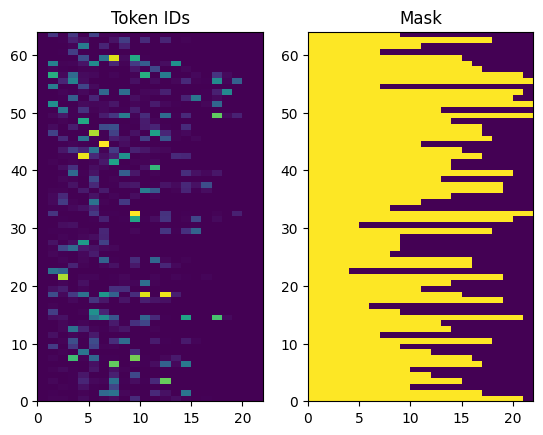

In [ ]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

In [ ]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train.map(process_text, tf.data.AUTOTUNE)
val_ds = val.map(process_text, tf.data.AUTOTUNE)

In [ ]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy())
  print()
  print(ex_tar_in[0, :10].numpy())
  print(ex_tar_out[0, :10].numpy())

[   2   12    9   46   14   24 2910   28   21    4]

[   2   11    5   44    8   19 1581   20   18    4]
[  11    5   44    8   19 1581   20   18    4    3]


### Build the model

In [ ]:
UNITS = 256

In [ ]:
#@title
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [ ]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 22)
Encoder output, shape (batch, s, units): (64, 22, 256)


In [ ]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()

    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)

    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')

    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [ ]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 22, 256)
Target sequence, shape (batch, t, units): (64, 21, 256)
Attention result, shape (batch, t, units): (64, 21, 256)
Attention weights, shape (batch, t, s):    (64, 21, 22)


In [ ]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([0.9999998 , 0.9999999 , 0.99999994, 1.        , 1.        ,
       0.9999999 , 1.        , 0.9999999 , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ], dtype=float32)

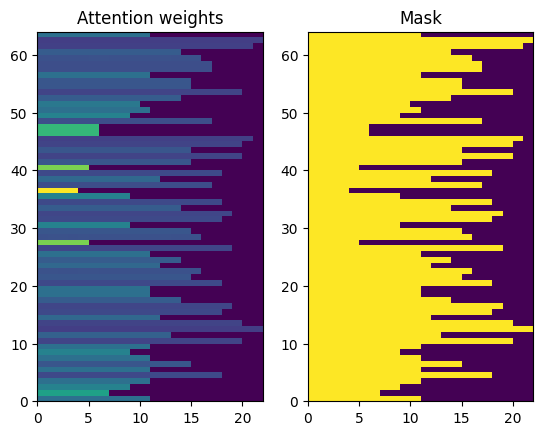

In [ ]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');


In [ ]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [ ]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

In [ ]:
decoder = Decoder(target_text_processor, UNITS)

In [ ]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 22, 256)
input target tokens shape: (batch, t) (64, 21)
logits shape shape: (batch, target_vocabulary_size) (64, 21, 5000)


In [ ]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [ ]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [ ]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True)

  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

  return next_token, done, state

In [ ]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'proposal requirement stakeholder amongst telecom compound scan bill car defeat',
       b'exist blackmail papers usd mainstream medium sme sectoral emission bio',
       b'comply finish representative substantive servant journey moral designate acquire downright'],
      dtype=object)

In [ ]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy.
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [ ]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 22)
Target tokens, shape: (batch, t) (64, 21)
logits, shape: (batch, t, target_vocabulary_size) (64, 21, 5000)


In [ ]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [ ]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [ ]:
model.compile(optimizer='adam',
              loss=masked_loss,
              metrics=[masked_acc, masked_loss])

In [ ]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 8.517193, 'expected_acc': 0.0002}

In [ ]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 14s 361ms/step - loss: 8.5252 - masked_acc: 6.2852e-04 - masked_loss: 8.5252


{'loss': 8.525233268737793,
 'masked_acc': 0.0006285218405537307,
 'masked_loss': 8.525233268737793}

### Train the model


In [ ]:
history = model.fit(
    train_ds.repeat(),
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=1)])

Epoch 1/100
100/100 [==============================] - 92s 802ms/step - loss: 5.5631 - masked_acc: 0.1977 - masked_loss: 5.5631 - val_loss: 4.6240 - val_masked_acc: 0.3122 - val_masked_loss: 4.6240
Epoch 2/100
100/100 [==============================] - 81s 818ms/step - loss: 3.9704 - masked_acc: 0.4147 - masked_loss: 3.9704 - val_loss: 3.0439 - val_masked_acc: 0.5517 - val_masked_loss: 3.0439
Epoch 3/100
100/100 [==============================] - 80s 802ms/step - loss: 2.2399 - masked_acc: 0.6758 - masked_loss: 2.2399 - val_loss: 1.8350 - val_masked_acc: 0.7250 - val_masked_loss: 1.8350
Epoch 4/100
100/100 [==============================] - 76s 761ms/step - loss: 1.2666 - masked_acc: 0.8254 - masked_loss: 1.2666 - val_loss: 1.1609 - val_masked_acc: 0.8308 - val_masked_loss: 1.1609
Epoch 5/100
100/100 [==============================] - 80s 795ms/step - loss: 0.8698 - masked_acc: 0.8836 - masked_loss: 0.8698 - val_loss: 0.6917 - val_masked_acc: 0.9138 - val_masked_loss: 0.6917
Epoch 6/10

### Evaluating the model

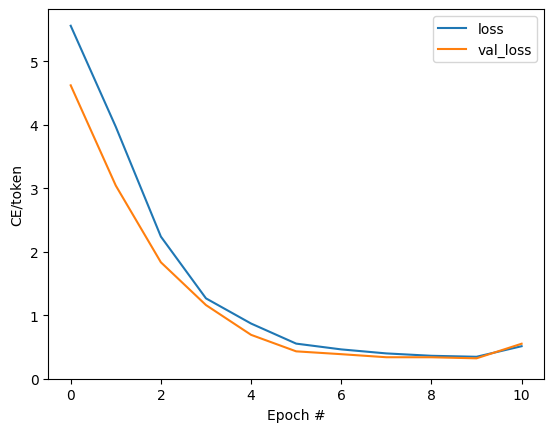

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

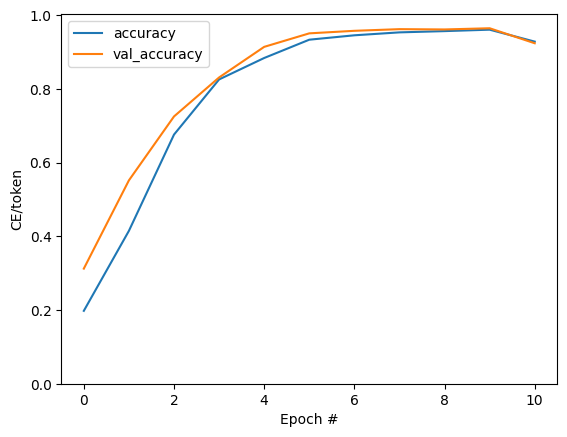

In [ ]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [ ]:
#@title
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)

    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [ ]:
# File paths
input_file_path = "/content/Data/src-test.txt"  # Replace with the path to your input text file
output_file_path = "/content/Data/tgt-pred-model1.txt"  # Replace with the desired path for the output text file

# Open the input file and read sentences
with open(input_file_path, "r", encoding="utf-8") as input_file:
    input_sentences = input_file.readlines()

# Perform translation and write to the output file
with open(output_file_path, "w", encoding="utf-8") as output_file:
    for sentence in input_sentences:
        # Perform translation for each sentence
        result = model.translate([sentence])
        decoded_sentence = result[0].numpy().decode()

        # Write the decoded sentence to the output file
        output_file.write(decoded_sentence + "\n")


### BLEU Scores and Translations

In [ ]:
!touch bleu.py

In [ ]:
!python bleu.py 1 /content/Data/tgt-test.txt  /content/Data/tgt-pred-model1.txt
!python bleu.py 2 /content/Data/tgt-test.txt  /content/Data/tgt-pred-model1.txt
!python bleu.py 3 /content/Data/tgt-test.txt  /content/Data/tgt-pred-model1.txt
!python bleu.py 4 /content/Data/tgt-test.txt  /content/Data/tgt-pred-model1.txt


0.9099586113692035
0.8671417480449437
0.8266565810620409
0.7906277229389418


In [ ]:
!head /content/Data/tgt-pred-model1.txt

date be not [UNK] . 
result speak for mselves . 
it should mean that everyone be give equal opportunity . 
europe have do very great deal work in this field , which be to welcome . 
we simply have to build it stage by stage . 
it be issue proportionality . 
we be talk about rights , [UNK] and freedom . 
that attempt do not succeed , but it do represent precedent for that kind . 
this green paper be important , see as it concern matter that need to be deal with . 
mr [UNK] ask follow question be you [UNK] sufficient size ? 


##OpenNMT


In [ ]:
# Install OpenNMT
!pip install OpenNMT-py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.3/257.3 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.8/36.8 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 110.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 117.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 34.1 MB/s eta 0:00:00


### Build the model


In [ ]:
!onmt_build_vocab -config /content/Data/config.yml -n_sample 100000

2023-11-18 14:27:55.556535: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-18 14:27:55.556591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-18 14:27:55.557929: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-18 14:27:56.586729: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-11-18 14:27:57.984233: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the gui

### Train the model

In [ ]:
!onmt_train -config /content/Data/config.yml

2023-11-18 14:28:13.083275: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-18 14:28:13.083334: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-18 14:28:13.084837: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-18 14:28:14.109109: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-11-18 14:28:15.523640: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the gui

### Evaluating the model


In [ ]:
!onmt_translate -model /content/Data/run/model_step_10000.pt -src Data/src-test.txt -output Data/tgt-pred-model2.txt -gpu 0 -verbose

Streaming output truncated to the last 5000 lines.
PRED 1: date be not foregone .
PRED SCORE: -0.4112

[2023-11-18 14:39:09,769 INFO] 
SENT 2: ['the', 'results', 'speak', 'for', 'themselves', '.']
PRED 2: result speak for mselves .
PRED SCORE: -0.0005

[2023-11-18 14:39:09,769 INFO] 
SENT 3: ['it', 'should', 'mean', 'that', 'everyone', 'is', 'given', 'an', 'equal', 'opportunity', '.']
PRED 3: it should mean that everyone be give equal opportunity .
PRED SCORE: -0.0002

[2023-11-18 14:39:09,770 INFO] 
SENT 4: ['europe', 'has', 'done', 'a', 'very', 'great', 'deal', 'of', 'work', 'in', 'this', 'field', ',', 'which', 'is', 'to', 'be', 'welcomed', '.']
PRED 4: europe have do very great deal work in this field , which be to be welcome .
PRED SCORE: -0.0015

[2023-11-18 14:39:09,770 INFO] 
SENT 5: ['we', 'simply', 'have', 'to', 'build', 'it', 'stage', 'by', 'stage', '.']
PRED 5: we simply have to build it stage by stage .
PRED SCORE: -0.0006

[2023-11-18 14:39:09,771 INFO] 
SENT 6: ['it', 'is

### BLEU Scores and Translations

In [ ]:
!touch bleu.py

In [ ]:
!python bleu.py 1 /content/Data/tgt-test.txt  /content/Data/tgt-pred-model2.txt
!python bleu.py 2 /content/Data/tgt-test.txt  /content/Data/tgt-pred-model2.txt
!python bleu.py 3 /content/Data/tgt-test.txt  /content/Data/tgt-pred-model2.txt
!python bleu.py 4 /content/Data/tgt-test.txt  /content/Data/tgt-pred-model2.txt


0.9418943424723365
0.9228918619284411
0.9050097347853664
0.8875022512809427


In [ ]:
!head /content/Data/tgt-pred-model2.txt

date be not foregone .
result speak for mselves .
it should mean that everyone be give equal opportunity .
europe have do very great deal work in this field , which be to be welcome .
we simply have to build it stage by stage .
it be issue proportionality .
we be talk about rights , semus and freedom .
that attempt do not succeed , but it do represent precedent for that kind gar .
this green paper be important , see as it concern matter that need to be deal with .
mr audy ask follow question be you blind sufficient size ?


# Hindi

## Preprocessing

In [ ]:
def extract_top_sentences_with_index(english_file, hindi_file, output_english_file, output_hindi_file, length_range, max_sentences=1000):
    # Read English and Hindi files
    with open(english_file, 'r', encoding='utf-8') as english_file, open(hindi_file, 'r', encoding='utf-8') as hindi_file:
        english_sentences = english_file.readlines()
        hindi_sentences = hindi_file.readlines()

    # Filter sentences based on length
    filtered_indexes = [index for index, sentence in enumerate(english_sentences) if length_range[0] <= len(sentence.split()) <= length_range[1]]

    # Limit the number of sentences to the top 1000
    filtered_indexes = filtered_indexes[:max_sentences]

    # Extract English and Hindi sentences with indexes
    filtered_english_sentences = [english_sentences[index].strip() for index in filtered_indexes]
    filtered_hindi_sentences = [hindi_sentences[index].strip() for index in filtered_indexes]

    # Write the filtered English sentences with indexes to the output file
    with open(output_english_file, 'w', encoding='utf-8') as english_output_file:
        for index, english_sentence in enumerate(filtered_english_sentences):
            english_output_file.write(f"{english_sentence}\n")

    # Write the filtered Hindi sentences with indexes to the output file
    with open(output_hindi_file, 'w', encoding='utf-8') as hindi_output_file:
        for index, hindi_sentence in enumerate(filtered_hindi_sentences):
            hindi_output_file.write(f"{hindi_sentence}\n")

if __name__ == "__main__":
    # English text file
    english_input_file = '/content/en_sent.txt'

    # Hindi text file
    hindi_input_file = '/content/hi_sent.txt'

    # Output files for English and Hindi sentences
    output_english_file = 'english.txt'
    output_hindi_file = 'hindi.txt'

    # Length range for sentences
    length_range = (5, 10)

    # Extract and write the top 1000 English and corresponding Hindi sentences with indexes
    extract_top_sentences_with_index(english_input_file, hindi_input_file, output_english_file, output_hindi_file, length_range, max_sentences=1000)



In [ ]:
import random

def split_data(src_file, tgt_file, src_train, src_test, src_val, tgt_train, tgt_test, tgt_val, train_percent=0.7, test_percent=0.15, val_percent=0.15):
    # Read source and target sentences
    with open(src_file, 'r', encoding='utf-8') as src_file:
        src_sentences = src_file.readlines()

    with open(tgt_file, 'r', encoding='utf-8') as tgt_file:
        tgt_sentences = tgt_file.readlines()

    # Check if the number of sentences in both files is the same
    if len(src_sentences) != len(tgt_sentences):
        print("Error: Number of sentences in source and target files do not match.")
        return

    total_sentences = len(src_sentences)
    indices = list(range(total_sentences))
    random.shuffle(indices)

    # Calculate the number of sentences for each split
    train_size = int(total_sentences * train_percent)
    test_size = int(total_sentences * test_percent)
    val_size = int(total_sentences * val_percent)

    # Split indices into train, test, and validation sets
    train_indices = indices[:train_size]
    test_indices = indices[train_size:train_size + test_size]
    val_indices = indices[train_size + test_size:]

    # Write source and target sets to separate files
    write_set(src_sentences, src_train, train_indices)
    write_set(src_sentences, src_test, test_indices)
    write_set(src_sentences, src_val, val_indices)

    write_set(tgt_sentences, tgt_train, train_indices)
    write_set(tgt_sentences, tgt_test, test_indices)
    write_set(tgt_sentences, tgt_val, val_indices)

def write_set(sentences, output_file, indices):
    with open(output_file, 'w', encoding='utf-8') as output_file:
        for index in indices:
            output_file.write(sentences[index])

if __name__ == "__main__":
    src_file_path = "/content/hindi.txt"
    tgt_file_path = "/content/english.txt"

    src_train_path = "src-train.txt"
    src_test_path = "src-test.txt"
    src_val_path = "src-val.txt"

    tgt_train_path = "tgt-train.txt"
    tgt_test_path = "tgt-test.txt"
    tgt_val_path = "tgt-val.txt"

    split_data(src_file_path, tgt_file_path, src_train_path, src_test_path, src_val_path, tgt_train_path, tgt_test_path, tgt_val_path)


## Hindi to English Translation(ONMT)



In [ ]:
# Install OpenNMT
!pip install OpenNMT-py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.3/257.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.8/36.8 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 92.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 79.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 63.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 29.7 MB/s eta 0:00:00


### Build the model


In [ ]:
!onmt_build_vocab -config /content/Data/config.yml -n_sample 100000

2023-11-19 08:28:02.905658: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-19 08:28:02.905729: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-19 08:28:02.905772: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-19 08:28:02.917537: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-19 08:28:04.979200: W tensorflow/compiler/

### Train the model

In [ ]:
!onmt_train -config /content/Data/config.yml

2023-11-19 08:28:15.680352: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-19 08:28:15.680405: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-19 08:28:15.680448: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-19 08:28:15.688768: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-19 08:28:17.104640: W tensorflow/compiler/

### Evaluating the model


In [ ]:
!onmt_translate -model /content/Data/run/model_step_10000.pt -src /content/Data/src-test.txt -output /content/hin-eng-onmt.txt -gpu 0 -verbose

Streaming output truncated to the last 5000 lines.
PRED 8823: “ But the wind … ”
PRED SCORE: -0.4673

[2023-11-19 08:39:01,310 INFO] 
SENT 8824: ['परिवर्तन', 'एक', 'मानक', 'टेम्पलेट', 'में', 'सहेजा', 'नहीं', 'जा', 'सकता', 'है.']
PRED 8824: Cannot load changes into standard template
PRED SCORE: -0.3229

[2023-11-19 08:39:01,310 INFO] 
SENT 8825: ['इन', 'वस्तुओं', 'को', 'प्रयोग', 'करने', 'में', 'ज्यादा', 'मज़ेदार', 'लगता', 'है।']
PRED 8825: It's more interesting to use these objects,
PRED SCORE: -0.6735

[2023-11-19 08:39:01,310 INFO] 
SENT 8826: ['समूह', 'के', 'लिए', 'नया', 'प्रश्न', 'जोड़ें']
PRED 8826: Add new question for group
PRED SCORE: -0.0636

[2023-11-19 08:39:01,311 INFO] 
SENT 8827: ['पूरे', 'अमरीका', 'में।']
PRED 8827: in the United States across the United States
PRED SCORE: -0.3477

[2023-11-19 08:39:01,311 INFO] 
SENT 8828: ['नए', 'विंडोज़', 'पिछले', 'विंडो', 'खाका', 'का', 'उपयोग', 'करें']
PRED 8828: Use new windows last window
PRED SCORE: -0.2220

[2023-11-19 08:39:01,31

### BLEU Scores and Translations

In [ ]:
!touch bleu.py

In [ ]:
!python bleu.py 1 /content/Data/tgt-test.txt  /content/hin-eng-onmt.txt
!python bleu.py 2 /content/Data/tgt-test.txt  /content/hin-eng-onmt.txt
!python bleu.py 3 /content/Data/tgt-test.txt  /content/hin-eng-onmt.txt
!python bleu.py 4 /content/Data/tgt-test.txt  /content/hin-eng-onmt.txt


0.9418943424723365
0.9228918619284411
0.9050097347853664
0.8875022512809427


In [ ]:
!head /content/hin-eng-onmt.txt

date be not foregone .
result speak for mselves .
it should mean that everyone be give equal opportunity .
europe have do very great deal work in this field , which be to be welcome .
we simply have to build it stage by stage .
it be issue proportionality .
we be talk about rights , semus and freedom .
that attempt do not succeed , but it do represent precedent for that kind gar .
this green paper be important , see as it concern matter that need to be deal with .
mr audy ask follow question be you blind sufficient size ?


## English to English Gloss


In [ ]:
# File paths
input_file_path = "/content/english.txt"  # Replace with the path to your input text file
output_file_path = "english-gloss-attention.txt"  # Replace with the desired path for the output text file

# Open the input file and read sentences
with open(input_file_path, "r", encoding="utf-8") as input_file:
    input_sentences = input_file.readlines()

# Perform translation and write to the output file
with open(output_file_path, "w", encoding="utf-8") as output_file:
    for sentence in input_sentences:
        # Perform translation for each sentence
        result = model.translate([sentence])
        decoded_sentence = result[0].numpy().decode()

        # Write the decoded sentence to the output file
        output_file.write(decoded_sentence + "\n")


In [ ]:
!onmt_translate -model /content/Data/run/model_step_10000.pt -src /content/english.txt -output /content/english-gloss-onmt.txt -gpu 0 -verbose

Streaming output truncated to the last 5000 lines.
PRED 1: shareholdersvote like to tell you about one such fingernail
PRED SCORE: -0.5650

[2023-11-19 07:03:05,224 INFO] 
SENT 2: ['<unk>', 'percentage', 'is', 'even', 'greater', 'than', 'the', 'percentage', 'in', '<unk>']
PRED 2: shareholdersvote percentage be even greater than percentage in 3.05
PRED SCORE: -0.5925

[2023-11-19 07:03:05,224 INFO] 
SENT 3: ['<unk>', 'authentication', 'required', 'for', '<unk>', 'connection', '<unk>']
PRED 3: varvitsiotus toma require for tac connection sam
PRED SCORE: -1.3942

[2023-11-19 07:03:05,225 INFO] 
SENT 4: ['2.', '<unk>', 'caused', 'by', '<unk>']
PRED 4: discharge ronald cause by 9.30
PRED SCORE: -1.0596

[2023-11-19 07:03:05,225 INFO] 
SENT 5: ['<unk>', 'ending', 'portion', 'of', 'these', '<unk>', 'is', 'called', '<unk>']
PRED 5: shareholdersvote end subcontracting se unification be call inwards
PRED SCORE: -1.0572

[2023-11-19 07:03:05,225 INFO] 
SENT 6: ['<unk>', 'this', 'lies', 'the', 'ci

## English Gloss to Hindi Gloss

In [ ]:
!pip install -q googletrans==4.0.0-rc1

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 6.3 MB/s eta 0:00:00


In [ ]:
from googletrans import Translator
# Create a Translator object
pred1_file_path = "/content/hindi-gloss-onmt.txt"
pred2_file_path = "/content/hindi-gloss-attention.txt"


translator = Translator()
with open("/content/english-gloss-onmt.txt", 'r', encoding='utf-8') as file:
        pred1 = file.readlines()
with open("/content/english-gloss-attention.txt", 'r', encoding='utf-8') as file:
        pred2 = file.readlines()

with open(pred1_file_path, "w", encoding="utf-8") as output_file:
  for i in range(1,50):
      pred_text = translator.translate(pred1[i], src='en', dest='hi').text
      output_file.write(pred_text + "\n")
      print(pred_text)

with open(pred2_file_path, "w", encoding="utf-8") as output_file:
  for i in range(1,50):
      tar_text =  translator.translate(pred2[i], src='en', dest='hi').text
      output_file.write(tar_text + "\n")
      print(tar_text)

शेयरधारकों का वोट प्रतिशत 3.05 में प्रतिशत से भी अधिक है
TAC कनेक्शन सैम के लिए varvitsiotus toma की आवश्यकता है
डिस्चार्ज रोनाल्ड कारण 9.30
शेयरहोल्डर्सवोट एंड सब -कॉन्ट्रैक्टिंग एसई यूनिफिकेशन कॉल इनवर्ड
Zocor इस झूठ की परिस्थिति 135.13 से पहले लोगों को
Zocor सुनिश्चित है कि आप उपयुक्त फॉर्म का उपयोग करें।
Zocor Period Botleneck ग्रे के साथ डिमिलिट्राइज़ेशन हो
Zocor Re किसी तरह का न्याय हो
शेयरहोल्डर्सवोट एप्लिकेशन एक ही निर्देशक पर डिमिलिट्रिअराइजेशन होगा?
varvitsiotis biphenyl अगर सभी ग्रे घर पर डीएनए लिखते हैं
2008 संगमरमर में शेयरहोल्डर्सवोट बाइफेनिल
Zocor se dynamics लोकप्रिय हो।
शेयरहोल्डरवोट वर्ल्ड पॉस 271 डायरी के बाद संगमरमर के बाद हो
अधिक विस्तार के लिए zocor biphenyl
शेयरहोल्डर्सवोट बाइफेनिल ऑफ़ कॉमपेटिशन वरविटोटस?
शेयरहोल्डरवोट आप इस एकीकरण को अमृतसर के पास जा सकते हैं
Zocor आप कल्पना करते हैं
शेयरधारकवोट भी ग्रामीण अनुनय में वित्तीय सुधार हो
Zocor अंतिम पाठ कहानी हो।
Zocor नेटवर्क सैम को नहीं हटाएं
मैं उस संगमरमर ट्रस्ट आउटलेट पर मानसिकता
शेयरहोल्डरवोट grà? ner फ़ाइल फ़ा